In [3]:
# Required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder
from sklearn.linear_model import RidgeCV, LassoCV
from scipy import stats
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Read the dataset

data = pd.read_csv("insurance.csv")

In [6]:
# Display the first 5 lines

data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [7]:
# Display the last 5 lines

data.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [8]:
# Overview of the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [9]:
# Display statistical features

data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [10]:
# Check the data shape

data.shape

(1338, 7)

In [11]:
# Check for missing data

data.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


In [12]:
# Repetitive data checking

data.duplicated().sum()

np.int64(1)

In [13]:
# Drop repetitive data

data[data.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [14]:
print(f"Rows: {data.shape[0]}\nColumns: {data.shape[1]}")

Rows: 1338
Columns: 7


In [15]:
# BMI Category

bins = [0, 18.5, 24.9, 29.9, np.inf]
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
data['bmi_category'] = pd.cut(data['bmi'], bins=bins, labels=labels)


In [16]:
# Age Groups

bins_age = [17, 30, 50, np.inf]
labels_age = ['Young', 'Middle-aged', 'Old']
data['age_group'] = pd.cut(data['age'], bins=bins_age, labels=labels_age)

In [17]:
# Smoker * BMI Interaction

data['smoker_bmi'] = data['smoker'].map({'yes': 1, 'no': 0}) * data['bmi']

In [18]:
# Whether has children or not

data['has_children'] = np.where(data['children'] > 0, 1, 0)

In [19]:
# Categorical and Numerical Variables

le = LabelEncoder()
data['sex'] = le.fit_transform(data['sex'])
data['smoker'] = le.fit_transform(data['smoker'])

categorical_features = ['sex', 'smoker', 'region', 'bmi_category', 'age_group']
numerical_features = ['age', 'bmi', 'children', 'charges', 'smoker_bmi', 'has_children']


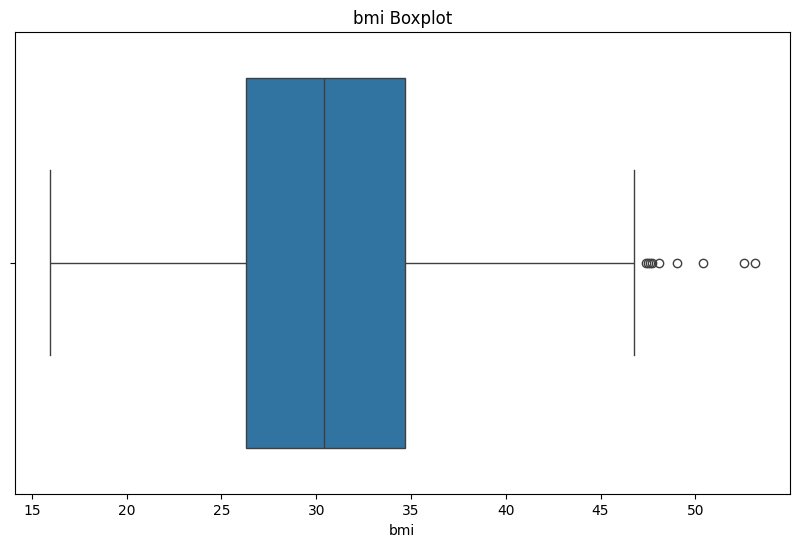

bmi - Outlier Count: 4


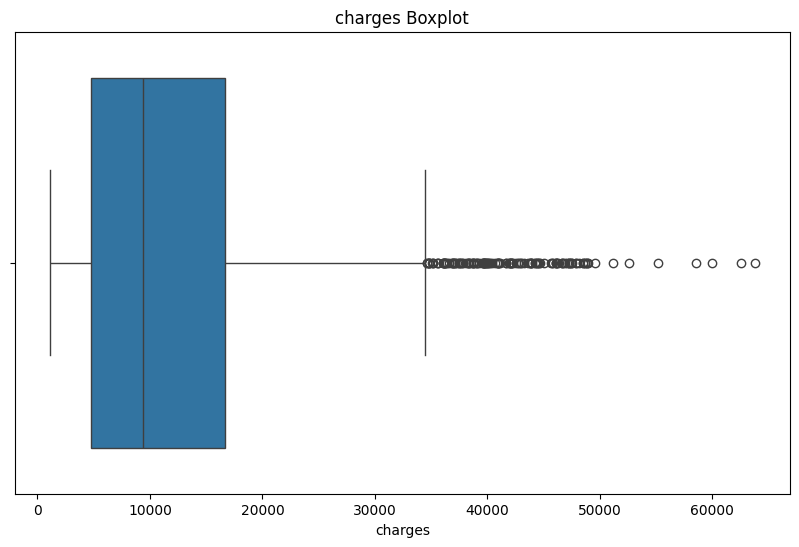

charges - Outlier Count: 7


In [20]:
# Outlier Analysis

for feature in ['bmi', 'charges']:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=data[feature])
    plt.title(f'{feature} Boxplot')
    plt.show()

    z_scores = np.abs(stats.zscore(data[feature]))
    outliers = np.where(z_scores > 3)
    print(f'{feature} - Outlier Count: {len(outliers[0])}')


In [22]:
# Winsorizing outliers

for feature in ['bmi', 'charges']:
    q_low = data[feature].quantile(0.01)
    q_high = data[feature].quantile(0.99)
    data[feature] = np.clip(data[feature], q_low, q_high)

In [23]:
# Standardization (Numerical Variables)

scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[numerical_features[:-1]] = scaler.fit_transform(data[numerical_features[:-1]])

In [24]:
# One-Hot Encoding (region, bmi_category, age_group)

data_encoded = pd.get_dummies(data_scaled, columns=['region', 'bmi_category', 'age_group'], drop_first=True)

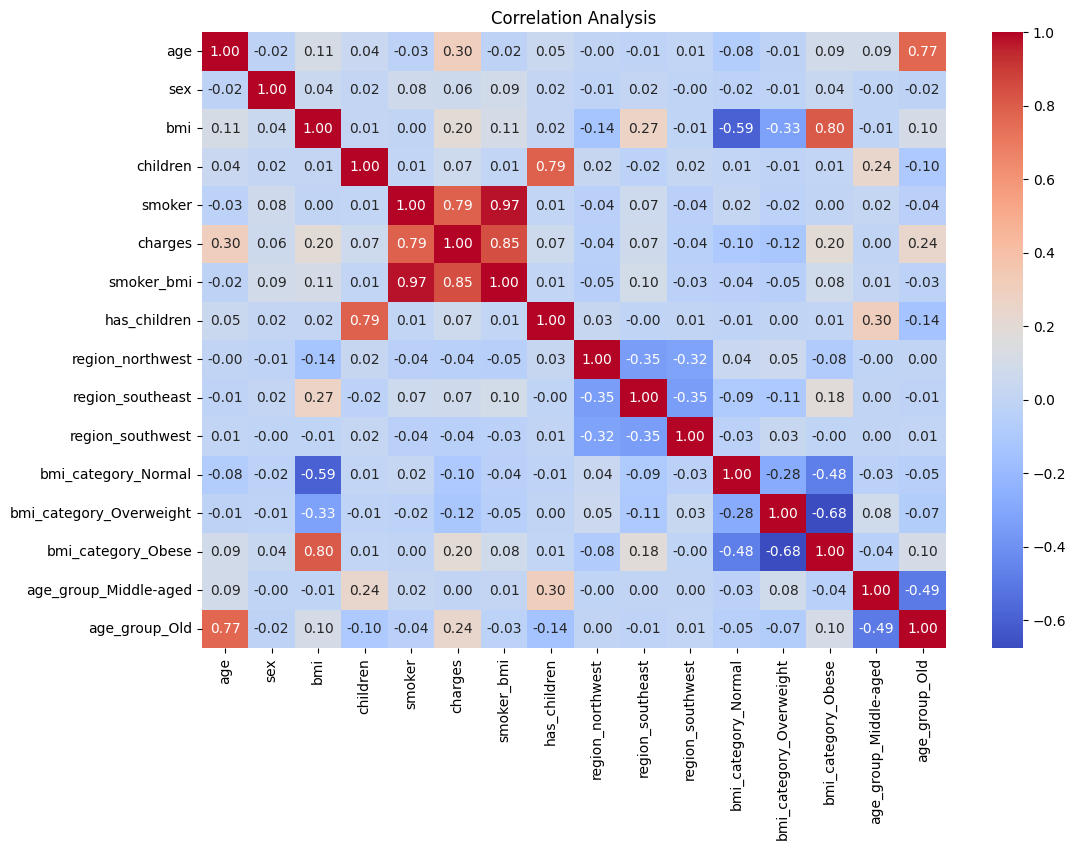

In [26]:
#  Correlation Matrix and Heatmap

plt.figure(figsize=(12,8))
sns.heatmap(data_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Analysis')
plt.show()

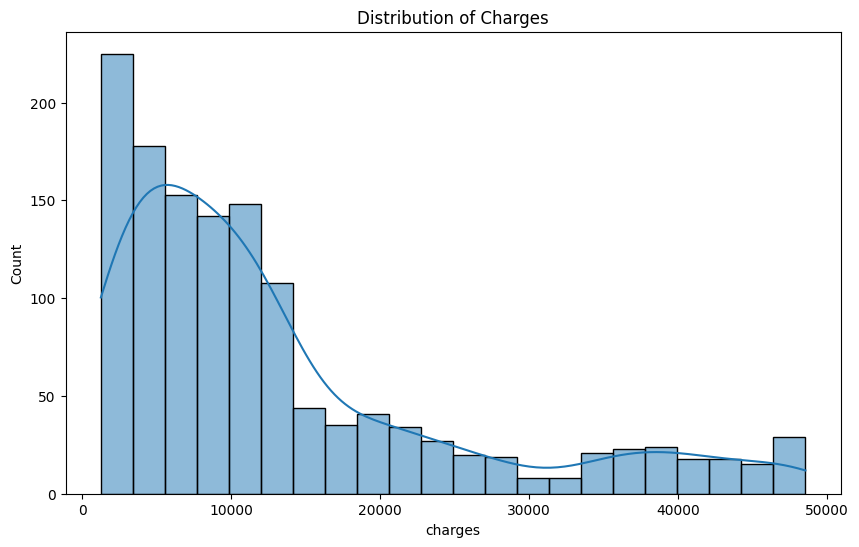

Charges Skewness: 1.4466411033943787


In [ ]:
# Target variable distribution

plt.figure(figsize=(10,6))
sns.histplot(data['charges'], kde=True)
plt.title('Distribution of Charges')
plt.show()
print(f"Charges Skewness: {data['charges'].skew()}")

In [29]:
# Train-Test Split

X = data_encoded.drop("charges", axis = 1)
y = data_encoded["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Linear Regression Model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print(f" Linear Regression MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")

 Linear Regression MSE: 0.14626872635235386
R2: 0.8612647719150737


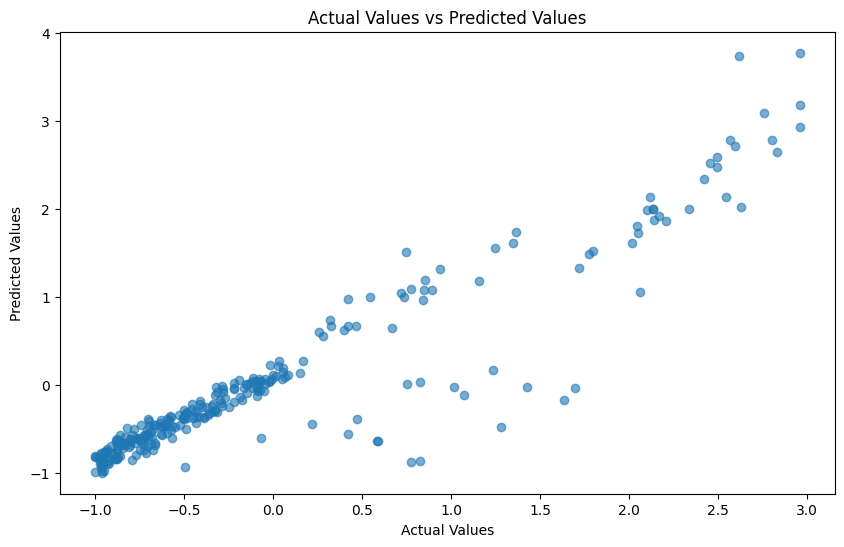

In [31]:
# Comparison of actual values and predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha = 0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual Values vs Predicted Values")
plt.show()

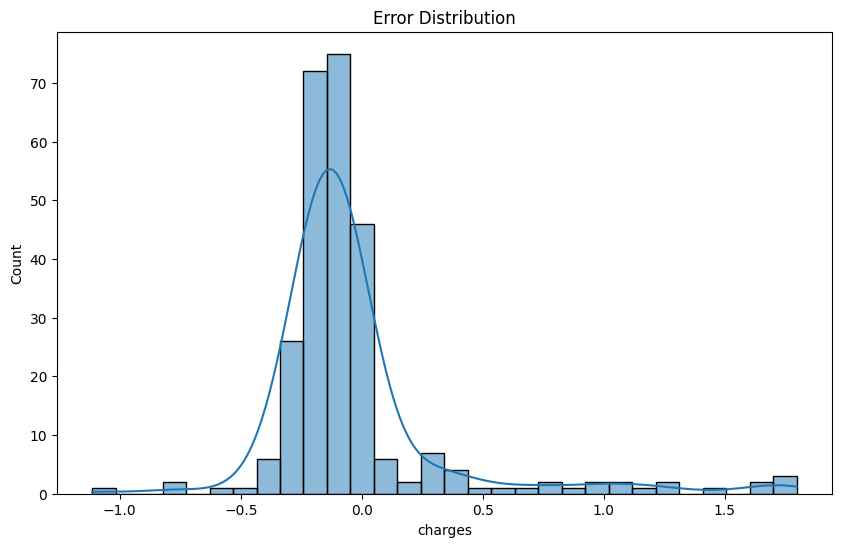

In [32]:
# Visualization of the error distribution

errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde = True)
plt.title("Error Distribution")
plt.show()

In [33]:
# Log Transformation

data_encoded['log_charges'] = np.log(data['charges'] + 1)
X_log = data_encoded.drop(['charges', 'log_charges'], axis=1)
y_log = data_encoded['log_charges']
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

In [35]:
# Log-transformed linear regression model

lr_log = LinearRegression()
lr_log.fit(X_train_log, y_train_log)
y_pred_log = lr_log.predict(X_test_log)

print(f"Log Transformed Linear Regression MSE: {mean_squared_error(y_test_log, y_pred_log)}")
print(f"Log Transformed Linear Regression R2: {r2_score(y_test_log, y_pred_log)}")

Log Transformed Linear Regression MSE: 0.1645519478642175
Log Transformed Linear Regression R2: 0.8155498068699697


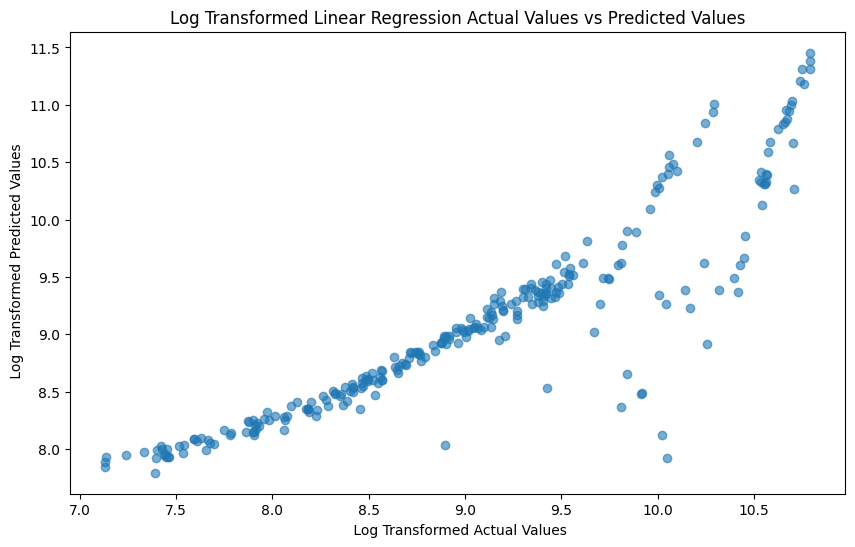

In [36]:
# Comparison of actual and predicted values with log-transformed linear regression model

plt.figure(figsize=(10, 6))
plt.scatter(y_test_log, y_pred_log, alpha = 0.6)
plt.xlabel(" Log Transformed Actual Values")
plt.ylabel(" Log Transformed Predicted Values")
plt.title("Log Transformed Linear Regression Actual Values vs Predicted Values")
plt.show()

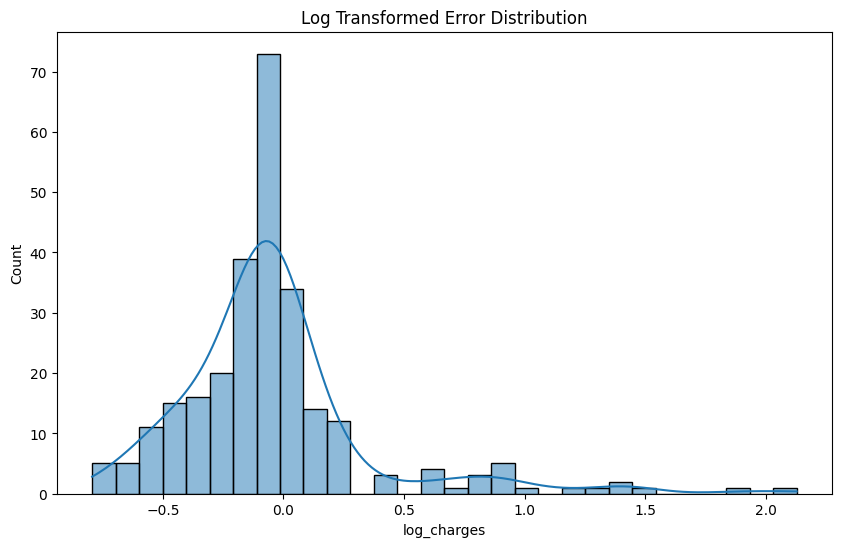

In [37]:
# Log transformed error distribution

errors_log = y_test_log - y_pred_log
plt.figure(figsize=(10, 6))
sns.histplot(errors_log, bins=30, kde = True)
plt.title("Log Transformed Error Distribution")
plt.show()

In [39]:
## Polynomial Regression

poly_results = {}
for degree in range(2, 5):
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

In [40]:
# Linear Regression Model for Each Degree Training and Evaluation

lr_poly = LinearRegression()
lr_poly.fit(X_train_poly, y_train)
y_pred_poly = lr_poly.predict(X_test_poly)

In [41]:
# MSE and values of R2 Calculation

mse = mean_squared_error(y_test, y_pred_poly)
r2 = r2_score(y_test, y_pred_poly)
poly_results[degree] = {'MSE': mse, 'R2': r2}

Text(0.5, 1.0, 'Actual Values vs Predicted')

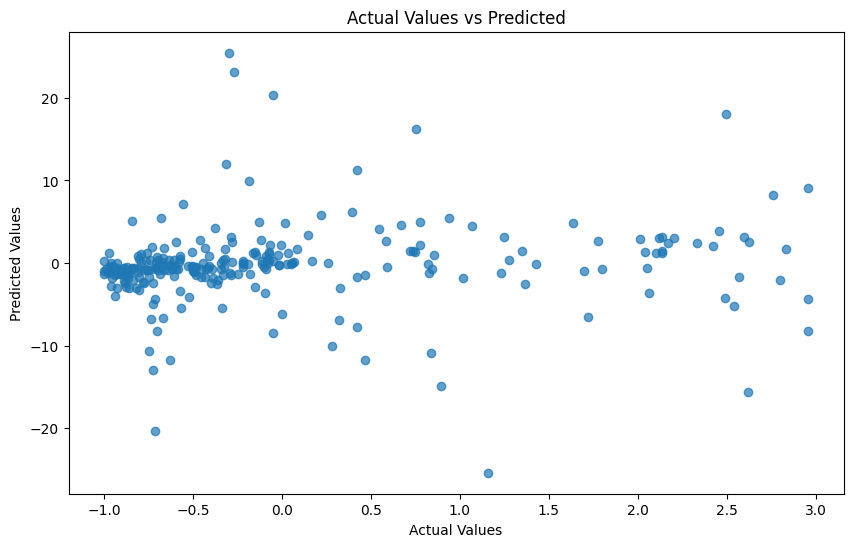

In [42]:
# Comparison of actual values and predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_poly, alpha = 0.7)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual Values vs Predicted")

<function matplotlib.pyplot.show(close=None, block=None)>

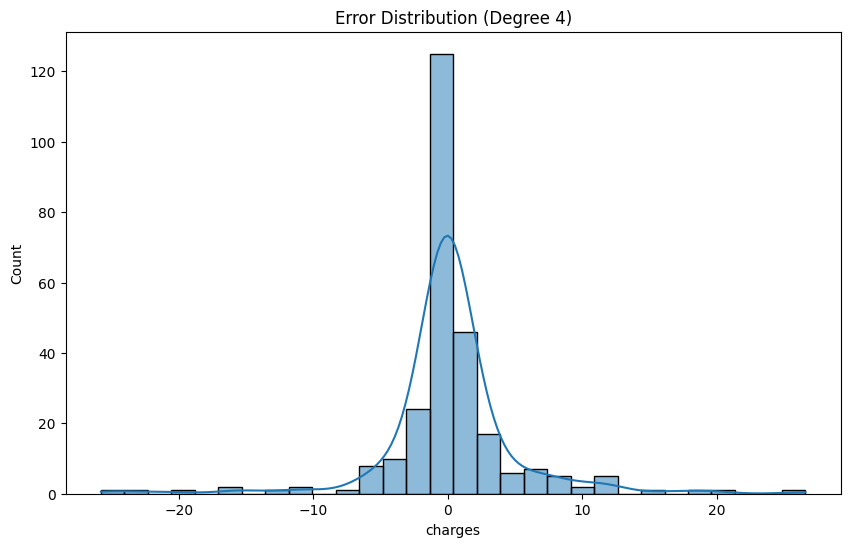

In [43]:
# Visualization of the error distribution

errors_poly = y_test - y_pred_poly
plt.figure(figsize=(10, 6))
sns.histplot(errors_poly, bins=30, kde = True)
plt.title(f"Error Distribution (Degree {degree})")
plt.show

In [44]:
# Determining the best alpha value

alphas = np.logspace(-3, 2, 100)


In [45]:
# Hyperparameter optimization for Ridge Regression model

ridge = Ridge()
param_grid_ridge = {'alpha': alphas}
grid_ridge = GridSearchCV(ridge, param_grid_ridge, scoring='neg_mean_squared_error', cv=5)
grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.12332403e-03, 1.26185688e-03, 1.41747416e-03,
       1.59228279e-03, 1.78864953e-03, 2.00923300e-03, 2.25701972e-03,
       2.53536449e-03, 2.84803587e-03, 3.19926714e-03, 3.59381366e-03,
       4.03701726e-03, 4.53487851e-03, 5.09413801e-03, 5.72236766e-03,
       6.42807312e-03, 7.22080902e-03, 8.11130831e-03, 9....
       6.89261210e+00, 7.74263683e+00, 8.69749003e+00, 9.77009957e+00,
       1.09749877e+01, 1.23284674e+01, 1.38488637e+01, 1.55567614e+01,
       1.74752840e+01, 1.96304065e+01, 2.20513074e+01, 2.47707636e+01,
       2.78255940e+01, 3.12571585e+01, 3.51119173e+01, 3.94420606e+01,
       4.43062146e+01, 4.97702356e+01, 5.59081018e+01, 6.28029144e+01,
       7.05480231e+01, 7.92482898e+01, 8.90215085e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [46]:
# Finding and predicting the best ridge value

best_ridge = grid_ridge.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)


print(f"Best Ridge Alpha: {grid_ridge.best_params_['alpha']}")
print(f"Ridge MSE: {mean_squared_error(y_test, y_pred_ridge)}")
print(f"Ridge R2: {r2_score(y_test, y_pred_ridge)}")


Best Ridge Alpha: 0.046415888336127795
Ridge MSE: 0.14612382888519337
Ridge R2: 0.8614022065099918


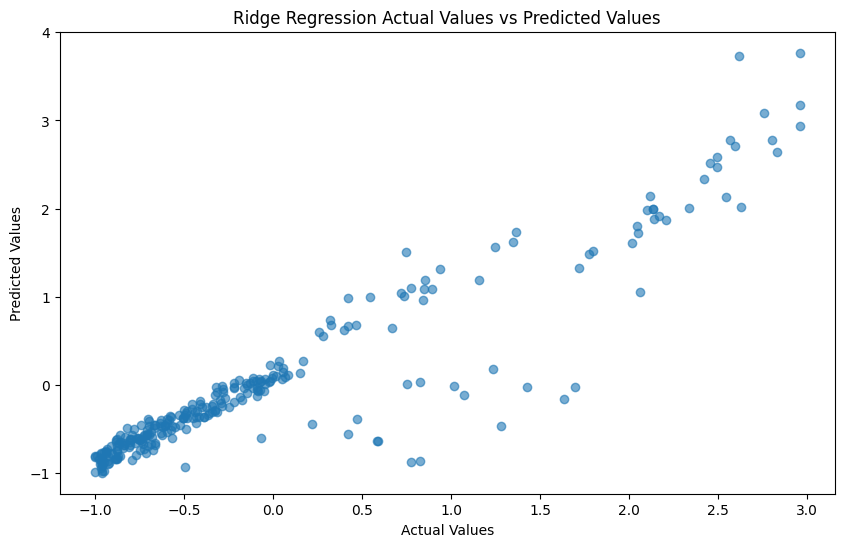

In [47]:
# Comparison of actual values and predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, alpha = 0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression Actual Values vs Predicted Values")
plt.show()

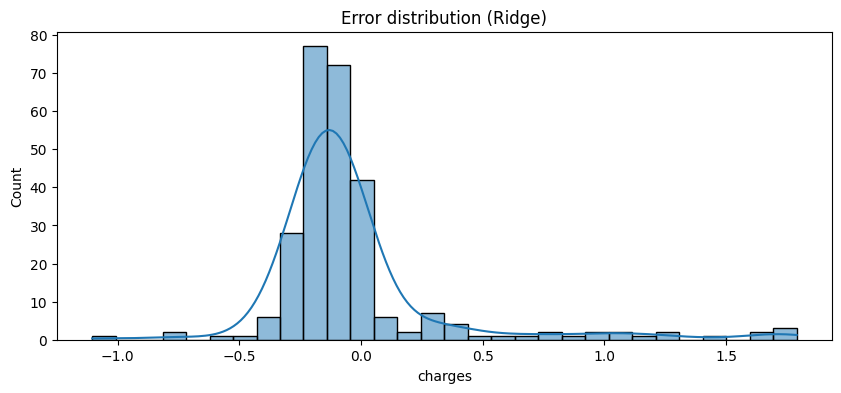

In [48]:
# # Visualization of the error distribution

errors_ridge = y_test - y_pred_ridge
plt.figure(figsize=(10,4))
sns.histplot(errors_ridge, bins=30, kde=True)
plt.title("Error distribution (Ridge)")
plt.show()

In [49]:
# Hyperparameter optimization for Lasso Regression model

lasso = Lasso(max_iter=10000)
param_grid_lasso = {'alpha': alphas}
grid_lasso = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=5)
grid_lasso.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(max_iter=10000),
             param_grid={'alpha': array([1.00000000e-03, 1.12332403e-03, 1.26185688e-03, 1.41747416e-03,
       1.59228279e-03, 1.78864953e-03, 2.00923300e-03, 2.25701972e-03,
       2.53536449e-03, 2.84803587e-03, 3.19926714e-03, 3.59381366e-03,
       4.03701726e-03, 4.53487851e-03, 5.09413801e-03, 5.72236766e-03,
       6.42807312e-03, 7.22080902e-03, 8.1...
       6.89261210e+00, 7.74263683e+00, 8.69749003e+00, 9.77009957e+00,
       1.09749877e+01, 1.23284674e+01, 1.38488637e+01, 1.55567614e+01,
       1.74752840e+01, 1.96304065e+01, 2.20513074e+01, 2.47707636e+01,
       2.78255940e+01, 3.12571585e+01, 3.51119173e+01, 3.94420606e+01,
       4.43062146e+01, 4.97702356e+01, 5.59081018e+01, 6.28029144e+01,
       7.05480231e+01, 7.92482898e+01, 8.90215085e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

In [50]:
# Finding and predicting the best lasso value

best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

print(f"Best Lasso Alpha: {grid_lasso.best_params_['alpha']}")
print(f"Lasso MSE: {mean_squared_error(y_test, y_pred_lasso)}")
print(f"Lasso R2: {r2_score(y_test, y_pred_lasso)}")

Best Lasso Alpha: 0.001
Lasso MSE: 0.14379909821850093
Lasso R2: 0.8636072030757147


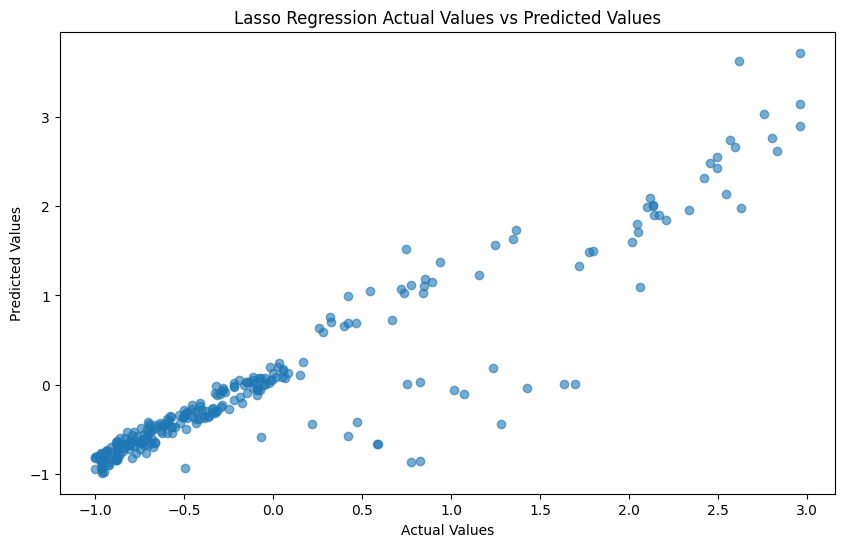

In [51]:
# Comparison of actual values and predicted values

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, alpha = 0.6)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Lasso Regression Actual Values vs Predicted Values")
plt.show()

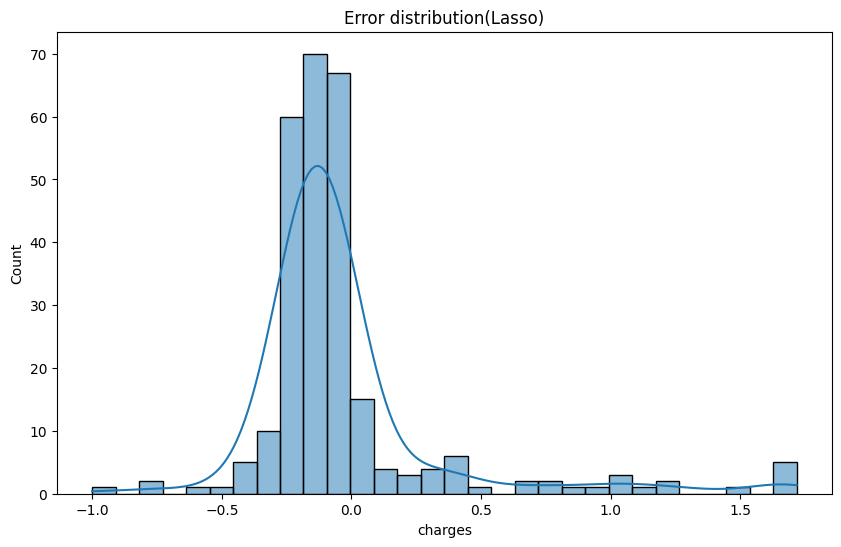

In [52]:
# Visualization of the error distribution

errors = y_test - y_pred_lasso
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=30, kde=True)
plt.title("Error distribution(Lasso)")
plt.show()

In [53]:
# Model Performance Comparison

model_results = pd.DataFrame({
    'Model': ['Linear', 'Linear Log', 'Ridge', 'Lasso'] + [f'Poly {d}' for d in poly_results.keys()],
    'MSE': [
        mean_squared_error(y_test, y_pred),
        mean_squared_error(y_test_log, y_pred_log),
        mean_squared_error(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_lasso)
    ] + [poly_results[d]['MSE'] for d in poly_results.keys()],
    'R2': [
        r2_score(y_test, y_pred),
        r2_score(y_test_log, y_pred_log),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_lasso)
    ] + [poly_results[d]['R2'] for d in poly_results.keys()]
})
print(model_results)

        Model        MSE         R2
0      Linear   0.146269   0.861265
1  Linear Log   0.164552   0.815550
2       Ridge   0.146124   0.861402
3       Lasso   0.143799   0.863607
4      Poly 4  24.621073 -22.352977


<Figure size 600x400 with 0 Axes>

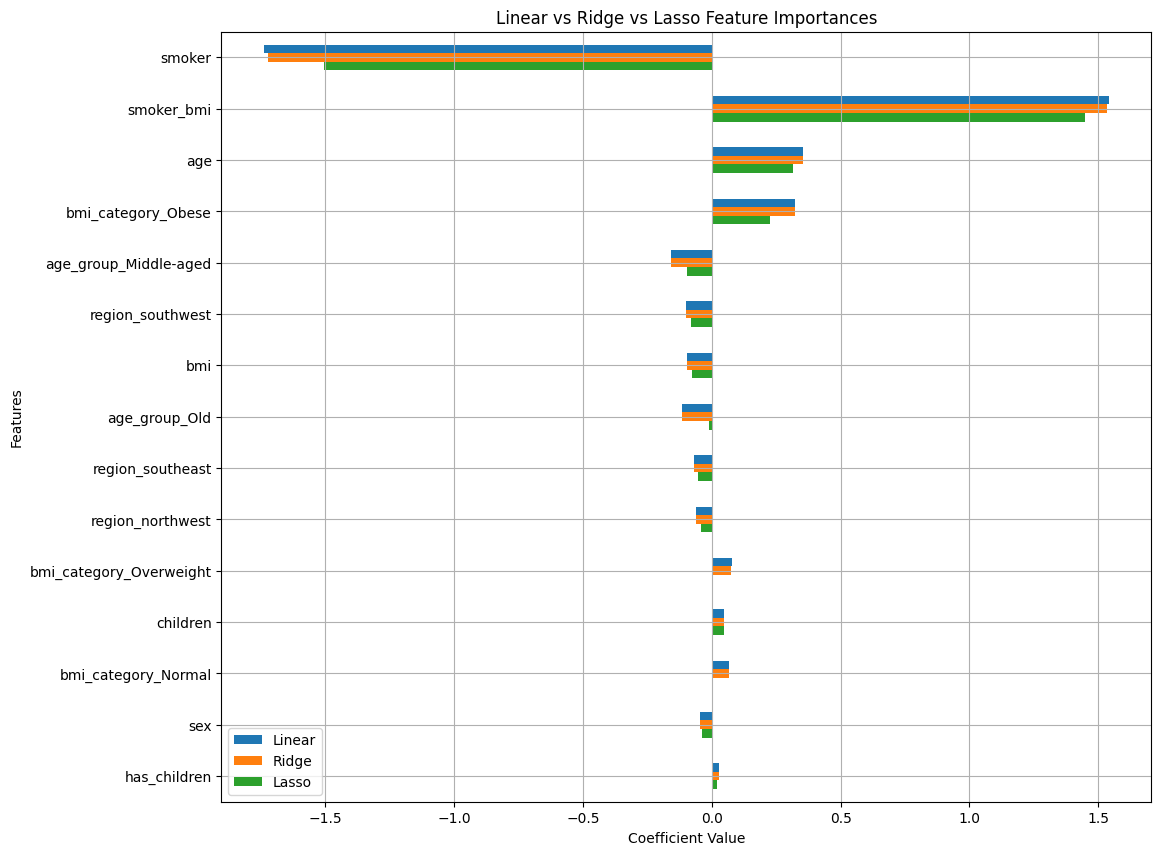

In [54]:
# Feature Importance Comparison of Ridge, Lasso and Linear Regression

coef_df = pd.DataFrame({
    'Linear': lr.coef_,
    'Ridge': best_ridge.coef_,
    'Lasso': best_lasso.coef_
}, index=X_train.columns)

coef_df['mean_coef'] = coef_df[['Linear', 'Ridge', 'Lasso']].abs().mean(axis=1)
coef_df = coef_df.sort_values(by='mean_coef', ascending=False)

plt.figure(figsize=(6,4))
coef_df[['Linear', 'Ridge', 'Lasso']].plot(kind='barh', figsize=(12,10))
plt.title("Linear vs Ridge vs Lasso Feature Importances")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.gca().invert_yaxis()
plt.legend()
plt.grid(True)
plt.show()

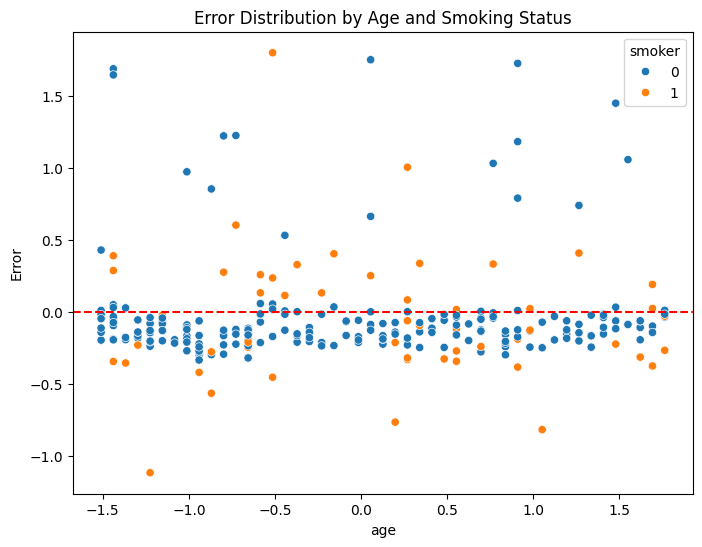

In [55]:
# Error Analysis

y_test_reset = y_test.reset_index(drop=True)
error_df = pd.DataFrame({'Actual': y_test_reset, 'Prediction': y_pred, 'Error': y_test_reset - y_pred})
error_df['age'] = X_test.reset_index(drop=True)['age']
error_df['smoker'] = X_test.reset_index(drop=True)['smoker']

plt.figure(figsize=(8,6))
sns.scatterplot(x='age', y='Error', hue='smoker', data=error_df)
plt.title("Error Distribution by Age and Smoking Status")
plt.axhline(0, linestyle='--', color='red')
plt.show()